<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>False Political Claim Detection</h1>
    <h3>Entrenamiento y evaluación de los modelos</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>

# Índice

1. [Importar librerias](#1.-Importar-librerias)
2. [Variables globales y funciones auxiliares](#2.-Variables-globales-y-funciones-auxiliares)
3. [Carga del dataframe](#3.-Carga-del-dataframe)
4. [Selección de las características](#4.-Seleccion-de-las-caracteristicas)
5. [Carga de los datos y división en entrenamiento y test](#5.-Carga-de-los-datos-y-division-en-entrenamiento-y-test)
6. [Preprocesado](#6.-Preprocesado)
    * 6.1 [Undersampling](#6.1-Undersampling)
    * 6.2 [Oversampling](#6.2-Oversampling)
7. [Modelos seleccionados](#7.-Modelos-seleccionados)
    * 7.1 [Introducción](#7.1-Introduccion)
    * 7.2 [Asignacion de las variables](#7.2-Asignacion-de-las-variables)
    * 7.3 [Clasificador XGBoost](#7.3-Clasificador-XGBoost)
8. [Exportar CSV](#8.-Exportar-CSV)
    * 8.1 [Asignacion de las variables](#8.1-Asignacion-de-las-variables)
    * 8.2 [Clasificador XGBoost](#8.2-Clasificador-XGBoost)
9. [Conclusiones generales](#9.-Conclusiones-generales)
10. [Referencias](#10.-Referencias)

# 1. Importar librerias

In [3]:
# General import and load data
import pandas as pd
import numpy as np

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Splitting
from sklearn.model_selection import train_test_split

# Estimators
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, recall_score, roc_curve, roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV

# Visualization
import matplotlib.pyplot as plt

# Time optimization
import time

print("Todas las librerias fueron correctamente importadas.")

Todas las librerias fueron correctamente importadas.


# 2. Variables globales y funciones auxiliares

Se fija un seed para todo el documento para fijar la aleatoriedad y así obtener resultados replicables.

In [6]:
seed = 42

Función utilizado para evaluar los distintos umbrales en la curva de ROC.

In [8]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

# 3. Carga del dataframe

Se cargan los datos de la ruta *formated/train_exportado.csv*, los cuales son los datos ya procesados por uno de nuestros compañeros.

In [11]:
url = "./formated/train_exportado_words.csv"
df = pd.read_csv(url)

print("Datos cargados correctamente\n")

Datos cargados correctamente



Observamos todas las columnas (se convierten a formato lista para observar la salida completa).

In [13]:
# Ver todas las columnas como lista completa
print(df.columns.tolist())

['id', 'label', 'statement_score', 'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas', 'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros', 'subject-politica_y_gobierno', 'subject-relaciones_internacionales', 'subject-salud_y_bienestar', 'subject-seguridad_y_justicia', 'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo', 'speaker_grouped_barack-obama', 'speaker_grouped_chain-email', 'speaker_grouped_donald-trump', 'speaker_grouped_hillary-clinton', 'speaker_grouped_john-mccain', 'speaker_grouped_marco-rubio', 'speaker_grouped_mitt-romney', 'speaker_grouped_other_speakers', 'speaker_grouped_rick-perry', 'speaker_grouped_rick-scott', 'speaker_grouped_scott-walker', 'speaker_job_grouped_business_professional', 'speaker_job_grouped_federal_legislative_candidate', 'speaker_job_grouped_federal_legislative_leader', 'speaker_job_grouped_federal_legislator_house', 'speaker_job_grouped_federal_legislator_senate', 'speaker_job_grouped_governor', 'speaker_job_g

También cargamos el test que debemos predecir para Kaggle de la ruta *formated/test_exportado.csv*.

In [15]:
url = "./formated/test_exportado_words.csv"
df_test = pd.read_csv(url)

print("Test cargado correctamente\n")

Test cargado correctamente



# 4. Seleccion de las caracteristicas

En el siguiente array se muestran todas las caracteristicas por si se decide realizar pruebas con otras *features*.

In [18]:
all_features = [
    # Identificador
    'id',

    # Etiqueta objetivo
    'label',

    # Score del texto
    'statement_score',

    # One-hot encoded de los temas reagrupados del texto
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',


    # One-hot de speaker_grouped
    'speaker_grouped_barack-obama', 'speaker_grouped_chain-email',
    'speaker_grouped_donald-trump', 'speaker_grouped_hillary-clinton',
    'speaker_grouped_john-mccain', 'speaker_grouped_marco-rubio',
    'speaker_grouped_mitt-romney', 'speaker_grouped_other_speakers',
    'speaker_grouped_rick-perry', 'speaker_grouped_rick-scott',
    'speaker_grouped_scott-walker',

    # One-hot de speaker_job_grouped
    'speaker_job_grouped_business_professional',
    'speaker_job_grouped_federal_legislative_candidate',
    'speaker_job_grouped_federal_legislative_leader',
    'speaker_job_grouped_federal_legislator_house',
    'speaker_job_grouped_federal_legislator_senate',
    'speaker_job_grouped_governor',
    'speaker_job_grouped_legal_professional',
    'speaker_job_grouped_local_education_official',
    'speaker_job_grouped_local_executive',
    'speaker_job_grouped_other_speaker_job',
    'speaker_job_grouped_party_leader',
    'speaker_job_grouped_political_advisor',
    'speaker_job_grouped_political_organization',
    'speaker_job_grouped_president',
    'speaker_job_grouped_presidential_candidate',
    'speaker_job_grouped_public_communicator',
    'speaker_job_grouped_state_executive',
    'speaker_job_grouped_state_legislator_house',
    'speaker_job_grouped_state_legislator_senate',

    # One-hot de state_info_grouped
    'state_info_grouped_arizona', 'state_info_grouped_california',
    'state_info_grouped_florida', 'state_info_grouped_georgia',
    'state_info_grouped_illinois', 'state_info_grouped_massachusetts',
    'state_info_grouped_new jersey', 'state_info_grouped_new york',
    'state_info_grouped_ohio', 'state_info_grouped_oregon',
    'state_info_grouped_other_state_info', 'state_info_grouped_rhode island',
    'state_info_grouped_texas', 'state_info_grouped_virginia',
    'state_info_grouped_washington dc', 'state_info_grouped_wisconsin',

    # One-hot de party_group
    'party_group_democrat', 'party_group_independent_None',
    'party_group_media', 'party_group_official',
    'party_group_organization', 'party_group_other',
    'party_group_republican', 'party_group_third_Party',
]

De las anteriores, solo nos quedaremos con las siguientes:

In [20]:
selected_features_1 = [
    # Score del texto
    'statement_score',

    ######################################################
    # One-hot encoded de los temas reagrupados del texto
    ######################################################
    # Mayor proporcion de falsas que el resto
    'subject-ciencia_y_tecnologia', 'subject-educacion',
    'subject-economia_y_finanzas', 'subject-relaciones_internacionales',

    # Mayor proporcion de verdaderas que el resto
    'subject-salud_y_bienestar', 'subject-sociedad_y_cultura',

    ######################################################
    # One-hot de speaker_grouped
    ######################################################
    # Mayor proporcion de falsas que el resto
    'speaker_grouped_hillary-clinton', 'speaker_grouped_john-mccain',
    'speaker_grouped_barack-obama',

     # Mayor proporcion de verdaderas que el resto
    'speaker_grouped_chain-email', 'speaker_grouped_donald-trump',
    'speaker_grouped_rick-perry', 'speaker_grouped_mitt-romney',

    ######################################################
    # One-hot de speaker_job_grouped
    ######################################################
    # Mayor proporcion de falsas que el resto
    'speaker_job_grouped_presidential_candidate',
    'speaker_job_grouped_federal_legislator_senate',
    'speaker_job_grouped_state_legislator_senate',
    'speaker_job_grouped_state_legislator_house',

    # Mayor proporcion de verdaderas que el resto
    'speaker_job_grouped_public_communicator',
    'speaker_job_grouped_legal_professional',
    'speaker_job_grouped_federal_legislative_leader',


    ######################################################
    # One-hot de state_info_grouped
    ######################################################
    # Mayor proporcion de falsas que el resto
    'state_info_grouped_ohio', 'state_info_grouped_illinois',
    'state_info_grouped_new jersey', 'state_info_grouped_georgia',
    'state_info_grouped_california',

    # Mayor proporcion de verdaderas que el resto
    'state_info_grouped_wisconsin', 'state_info_grouped_massachusetts',

    ######################################################
    # One-hot de state_info_grouped
    ######################################################
    # Mayor proporcion de falsas que el resto
    'party_group_official', 'party_group_democrat',
    'party_group_media',

    # Mayor proporcion de verdaderas que el resto
    'party_group_organization', 'party_group_republican',
]

Y de las anteriores, nos volvemos a quedar solamente con las siguientes (para una prueba más agresiva):

In [22]:
selected_features_2 = [
    # Score del texto
    'statement_score',

    ######################################################
    # One-hot encoded de los temas reagrupados del texto
    ######################################################
    # Mayor proporcion de falsas que el resto
    'subject-ciencia_y_tecnologia',

    # Mayor proporcion de verdaderas que el resto
    'subject-salud_y_bienestar',

    ######################################################
    # One-hot de speaker_grouped
    ######################################################
    # Mayor proporcion de falsas que el resto
    'speaker_grouped_hillary-clinton', 'speaker_grouped_john-mccain',
    'speaker_grouped_barack-obama',

     # Mayor proporcion de verdaderas que el resto
    'speaker_grouped_chain-email', 'speaker_grouped_donald-trump',
    'speaker_grouped_rick-perry', 'speaker_grouped_mitt-romney',

    ######################################################
    # One-hot de speaker_job_grouped
    ######################################################
    # Mayor proporcion de falsas que el resto
    'speaker_job_grouped_presidential_candidate',
    'speaker_job_grouped_federal_legislator_senate',
    'speaker_job_grouped_state_legislator_senate',

    # Mayor proporcion de verdaderas que el resto
    'speaker_job_grouped_public_communicator',
    'speaker_job_grouped_legal_professional',
    'speaker_job_grouped_federal_legislative_leader',


    ######################################################
    # One-hot de state_info_grouped
    ######################################################
    # Mayor proporcion de falsas que el resto
    'state_info_grouped_ohio', 'state_info_grouped_illinois',

    # Mayor proporcion de verdaderas que el resto
    'state_info_grouped_wisconsin', 'state_info_grouped_massachusetts',

    ######################################################
    # One-hot de state_info_grouped
    ######################################################
    # Mayor proporcion de falsas que el resto
    'party_group_official', 'party_group_democrat',
    'party_group_media',

    # Mayor proporcion de verdaderas que el resto
    'party_group_organization', 'party_group_republican',
]

# 5. Carga de los datos y division en entrenamiento y test

Cargamos las caracteristicas seleccionadas en la variable X y el objetivo *label* en la variable y.

In [25]:
X = df[selected_features_2]
y = df['label'].values

Se separa ya en entrenamiento y test para no falsear los datos del test al realizar el balanceo.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

A la hora de subir el modelo a Kaggle, ya se nos da dividido el entrenamiento y el test. Por ello, se utilizarán todos los datos tratados como entrenamiento (aunque también se le aplicará el mejor caso de preprocesado para cada modelo).

In [29]:
X_train_final = X
y_train_final = y

X_test_final = df_test[selected_features_2]

# 6. Preprocesado

Al haber escogido manualmente las características y el texto ya esta procesado en forma de una nota en función de las palabras que empleaba la frase, solamente será necesario tratar el desbalance entre clases. Para ello se realiza primero un *undersampling* con *RandomUnderSampler* y, después, se hacer un *oversampling* con un *SMOTE*.

## 6.1 Undersampling

Primero se realiza un undersampling al conjunto para el análisis.

In [34]:
under = RandomUnderSampler(sampling_strategy=0.7, random_state=seed)
X_under, y_under = under.fit_resample(X_train, y_train)

Después el de Kaggle.

In [36]:
under_final = RandomUnderSampler(sampling_strategy=0.7, random_state=seed)
X_under_final, y_under_final = under_final.fit_resample(X_train_final, y_train_final)

## 6.2 Oversampling

Primero se realiza un oversampling al conjunto para el análisis.

In [39]:
over = SMOTE(sampling_strategy=0.9, random_state=seed)
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

Después el de Kaggle.

In [41]:
over_final = SMOTE(sampling_strategy=0.9, k_neighbors=5, random_state=seed)
X_res_final, y_res_final = over_final.fit_resample(X_under_final, y_under_final)

# 7. Modelos seleccionados

## 7.1 Introduccion

Debido a la faalta de tiempo cuando nos dispusimos a realizar este *notebook* solo se ha evaluado el modelo *XGBoost* al tratarse del mejor modelo obtenido tanto durante el análisis de modelos, como al aplicar TF-IDF y como al aplicar Word2vec. Cabe resaltar que aunque fuese el mejor para todos ellos no tenia por qué ser el mejor para ahora ya que hemos cambiado las variables de entrada al fin y al cabo.

## 7.2 Asignacion de las variables

Asignamos las variables para el analisis en función del desarrollo del apartado del preprocesado.

In [47]:
X_model = X_resampled
y_model = y_resampled

X_model_test = X_test
expected = y_test

## 7.3 Clasificador XGBoost

### 7.4.1 Definicion

Definimos el modelo con los hiperparámetros *random_state* fijado y *class_weigth* balanceado. También se escoje *n_jobs* con valor -1 para utilizar todos los procesadores.

In [51]:
model_XG = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=seed)

### 7.4.2 Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [54]:
model_XG.fit(X_model, y_model)

predicted_XG = model_XG.predict(X_model_test)

In [55]:
accuracy_score(expected, predicted_XG)

0.7240223463687151

### 7.4.3 Null accuracy

Nuestra exactitud es de 0.724, la cual es peor que la *null accuracy*, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

### 7.4.4 Matriz de confusion y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [60]:
print(confusion_matrix(expected, predicted_XG))

[[439 172]
 [322 857]]


In [61]:
print(classification_report(expected, predicted_XG))

              precision    recall  f1-score   support

           0       0.58      0.72      0.64       611
           1       0.83      0.73      0.78      1179

    accuracy                           0.72      1790
   macro avg       0.70      0.72      0.71      1790
weighted avg       0.75      0.72      0.73      1790



Se observan unos grandes resultados tanto para los 0s como para los 1s.

### 7.4.5 ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

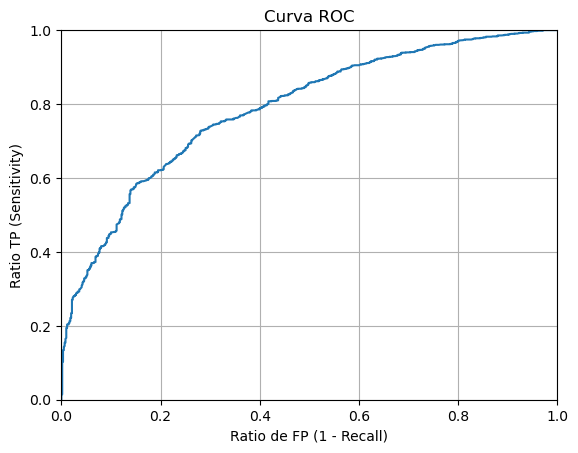

In [65]:
y_pred_prob_XG = model_XG.predict_proba(X_model_test)[:,1]
fpr, tpr, thresholds = roc_curve(expected, y_pred_prob_XG)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [67]:
thresholds

array([       inf, 0.9988097 , 0.9979017 , 0.99788636, 0.9963213 ,
       0.9961998 , 0.99609524, 0.9960742 , 0.995695  , 0.99284357,
       0.9921938 , 0.9916426 , 0.99141735, 0.99103326, 0.9909506 ,
       0.9907416 , 0.990126  , 0.9900203 , 0.9899942 , 0.98990566,
       0.9892356 , 0.98918706, 0.9891122 , 0.9798964 , 0.9797258 ,
       0.9796753 , 0.979364  , 0.9789219 , 0.9787336 , 0.97866315,
       0.97837913, 0.9775004 , 0.9769356 , 0.97513086, 0.9748064 ,
       0.9740389 , 0.97274506, 0.9719847 , 0.97152746, 0.9700983 ,
       0.96946543, 0.96898794, 0.96887434, 0.96818507, 0.96806395,
       0.9649626 , 0.9649342 , 0.9630109 , 0.9628313 , 0.96187663,
       0.96079403, 0.9596686 , 0.95901895, 0.95411026, 0.95396715,
       0.9531964 , 0.95246285, 0.95105493, 0.9510016 , 0.94791734,
       0.9475254 , 0.9470268 , 0.9469881 , 0.94390273, 0.94371486,
       0.9420997 , 0.9412903 , 0.9394405 , 0.9385079 , 0.9349706 ,
       0.9348681 , 0.9326712 , 0.9318715 , 0.9315721 , 0.93080

La curva presenta una buena forma, al contrario de lo que ocurria en otros *notebooks*.

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

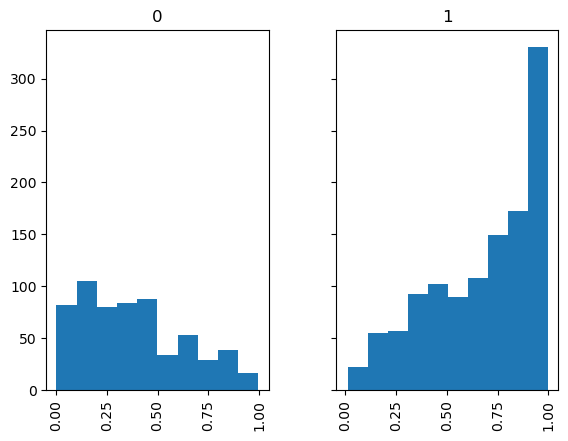

In [70]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_XG, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra que los mejores resultados para ambas clases se obtiene con el *threshold* igual a 0.5 aproximandamente (es decir, el valor por defecto).

In [72]:
best_thres_XG = 0.5

evaluate_threshold(best_thres_XG)

Sensitivity: 0.7268871925360475
Recall: 0.718494271685761


Con este valor se obtienen los siguientes resultados. Primero se recalculan las predicciones.

In [74]:
probs_XG = model_XG.predict_proba(X_model_test)[:, 1]
pred_thres_XG= (probs_XG >= best_thres_XG).astype(int)

Se evalua la matriz de confusión.

In [76]:
print(confusion_matrix(expected, pred_thres_XG))

[[439 172]
 [322 857]]


Y también se analiza el informe de la clasificación.

In [78]:
print(classification_report(expected, pred_thres_XG))

              precision    recall  f1-score   support

           0       0.58      0.72      0.64       611
           1       0.83      0.73      0.78      1179

    accuracy                           0.72      1790
   macro avg       0.70      0.72      0.71      1790
weighted avg       0.75      0.72      0.73      1790



Obviamente son los mismos, ya que no estamos modificando el umbral realmente.

Finalmente se calcula el valor de AUC.

In [81]:
print(roc_auc_score(expected, predicted_XG))

0.7226907321109043


Se ha obtenido un valor entre 0.7 y 0.7, es decir, el modelo se considerá como no tan bueno o *C*.

### 7.4.6 Optimizacion

Ahora seleccionamos los hiperparámetros a evaluar mediante un GridSearchCV. Además, se ha añadido la librería *time* para saber el tiempo que tardo en realizar la busqueda de mejores parámetros.

Estos hiperparámetros son:
* ***max_depth***: máxima profundidad de cada árbol.
* ***eta***: también llamado *learning_rate*,es un factor de escala que regula cuánto se actualizan los pesos en cada paso de boosting.
* ***n_estimators***: número de árboles.
* ***subsample***: proporción usada para entrenar cada árbol.
* ***colsample_bytree***: fracción de columnas utilizadas para construir cada árbol.

Debido a *Hugging Face* se aprendió a utilizar *Google Collab* y junto a su GPU. Por ello se abordó un *GridSearchCV* más grande ya que el tiempo de ejecución tampoco fue tan alto.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.4.7 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros (no se define con *grid_search.best_params_* para probar varias opciones de forma sencilla).

In [92]:
params_final_XG = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 3,
    'eta': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 1,
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [94]:
final_XG = XGBClassifier(**params_final_XG)

#### - Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [97]:
final_XG.fit(X_model, y_model)

predicted_XG_opt = final_XG.predict(X_model_test)

In [98]:
accuracy_score(expected, predicted_XG_opt)

0.7340782122905027

#### - Null accuracy

La accuracy es similar a la anterior y sigue siendo superior a la *null accuracy*.

#### - Matriz de confusion y F-score

La matriz de confusión y el informe de clasificación también es muy similar.

In [103]:
print(confusion_matrix(expected, predicted_XG_opt))

[[438 173]
 [303 876]]


In [104]:
print(classification_report(expected, predicted_XG_opt))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65       611
           1       0.84      0.74      0.79      1179

    accuracy                           0.73      1790
   macro avg       0.71      0.73      0.72      1790
weighted avg       0.75      0.73      0.74      1790



#### - ROC y AUC

Se calcula el ROC y se reajusta el umbral de probabilidad.

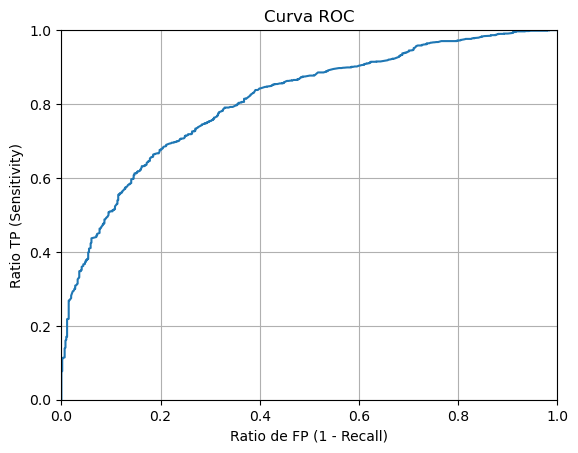

In [107]:
y_pred_prob_XG = final_XG.predict_proba(X_model_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_XG)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [108]:
thresholds

array([       inf, 0.9958619 , 0.99469143, 0.9922691 , 0.99158996,
       0.9914199 , 0.99094194, 0.9904828 , 0.9890969 , 0.98705   ,
       0.9864281 , 0.9856425 , 0.98561674, 0.9852732 , 0.98374397,
       0.9836758 , 0.98308414, 0.9819334 , 0.98162144, 0.9794694 ,
       0.97837377, 0.97816396, 0.9763017 , 0.97591215, 0.9739696 ,
       0.97353834, 0.97033846, 0.9696446 , 0.969256  , 0.9675163 ,
       0.9667163 , 0.9666541 , 0.96657807, 0.96393645, 0.96370006,
       0.9630321 , 0.96199757, 0.9607918 , 0.959834  , 0.9590329 ,
       0.9575737 , 0.9558921 , 0.955711  , 0.9534116 , 0.95281   ,
       0.9522984 , 0.94629616, 0.94458586, 0.944226  , 0.9411261 ,
       0.9387982 , 0.9386954 , 0.938015  , 0.93788135, 0.936291  ,
       0.9360962 , 0.9289645 , 0.92809653, 0.9268974 , 0.9267004 ,
       0.9126656 , 0.9124721 , 0.91086614, 0.9106158 , 0.91010976,
       0.9096105 , 0.90796363, 0.9076463 , 0.9075993 , 0.907309  ,
       0.9040515 , 0.9019202 , 0.9001582 , 0.9000526 , 0.89815

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

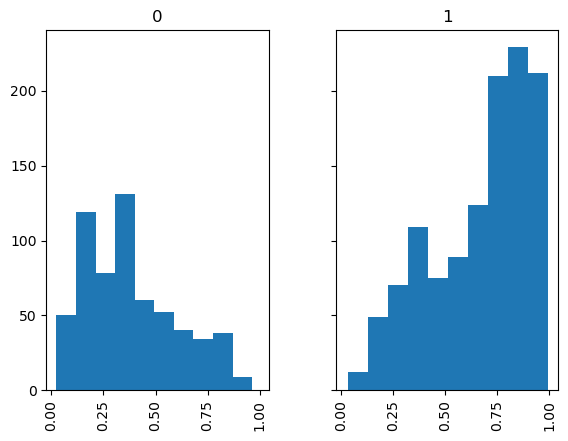

In [109]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_XG, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [110]:
op_thres_XG = 0.5

evaluate_threshold(op_thres_XG)

Sensitivity: 0.7430025445292621
Recall: 0.7168576104746318


In [111]:
probs_XG_opt = final_XG.predict_proba(X_model_test)[:, 1]
pred_thres_XG_opt = (probs_XG_opt >= op_thres_XG).astype(int)

In [112]:
print(confusion_matrix(expected, pred_thres_XG_opt))

[[438 173]
 [303 876]]


In [113]:
print(classification_report(expected, pred_thres_XG_opt))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65       611
           1       0.84      0.74      0.79      1179

    accuracy                           0.73      1790
   macro avg       0.71      0.73      0.72      1790
weighted avg       0.75      0.73      0.74      1790



Se obtienen los mismos resultados porque sigue siendo el mejor caso con umbral igual a 0,5.

Se calcula la AUC score.

In [116]:
print(roc_auc_score(expected, predicted_XG_opt))

0.7299300775019469


También ha tenido una pequeña mejora, pero sigue en el mismo intervalo. Es decir, sigue siendo un modelo *C*.

# 8. Exportar CSV

## 8.1 Asignacion de las variables

Asignamos las variables para el analisis en función del desarrollo del apartado del preprocesado.

In [121]:
X_kaggle = X_res_final
y_kaggle = y_res_final

X_kaggle_test = X_test_final

## 8.2 Clasificador XGBoost

In [123]:
params_final_XG = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 3,
    'eta': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 1,
    'random_state': seed
}

In [124]:
final_XG = XGBClassifier(**params_final_XG)

In [125]:
final_XG.fit(X_kaggle, y_kaggle)

probs_XG_final = final_XG.predict_proba(X_kaggle_test)[:, 1]
pred_thres_XG_final = (probs_XG_final >= 0.5).astype(int)

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [127]:
df_label_XG = pd.DataFrame(pred_thres_XG_final, columns=['label'])

In [128]:
df_id = df_test['id'].reset_index(drop=True)

In [129]:
df_final_XG = pd.concat([df_id, df_label_XG], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [131]:
df_final_XG['label'].value_counts()

label
1    2118
0    1718
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [133]:
df_final_XG.to_csv('./submit/xgboostselectivo.csv', index=False)

# 9. Conclusiones generales

Apesar de obtener grandes resultados durante todo el *notebook* los resultados en *Kaggle* no fueron buenos, incluso peores que los modelos aplicado TF-IDF. Creemos que esto se debe a que el conjunto de datos de entrenamiento no es tan similar al conjunto de test de *Kaggle*. Esto provocó que aunque obtuviesemos buenos indicadores para reducir las dimensiones manualmente (como se puede ver la mejora en los resultados del apartado 7), estos no lo fueras para el conjunto de test. Es decir, los buenos resultados no se debían a un bueno modelado sino a un *overfitting* de los datos.

# 10. Referencias

* [GridSearchCV. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [RandomUnderSampler — Version 0.13.0. (s. f.). Imbalance learn.](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html)
* [SMOTE — Version 0.13.0. (s. f.). Imbalanced learn.](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
* [train_test_split. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* [XGBoost Parameters — xgboost 3.0.0 documentation. (s. f.).](https://xgboost.readthedocs.io/en/release_3.0.0/parameter.html)